# Linear sweep voltammetry (LSV)
Peter Attia, May 17 2020

This notebook plots the first lithiation of carbon black electrodes as a function of sweep rate.

In [1]:
import re
import glob
from pathlib import Path

import numpy as np
from scipy.signal import savgol_filter
from scipy.integrate import cumtrapz
import pandas as pd
import pint

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Define pint unit registry and common units

In this notebook, I use the `pint` package to reduce unit conversion errors.

In [3]:
ureg = pint.UnitRegistry()

Define typical electrode mass. Unfortunately, the true values were unavailable, so we use nominal masses here:

In [4]:
electrode_mass = 0.8 * ureg.mg

#### Electrode area

Define typical electrode area in cm^2:

In [5]:
SSA = 62 * ureg.m ** 2 / ureg.g # specific surface area of carbon black

electrode_area = SSA * electrode_mass
electrode_area.ito('cm**2')
electrode_area

496.0 <Unit('centimeter ** 2')>

## Load data

In [6]:
file_list = sorted(list((Path.cwd()).glob('*.txt')))
file_list

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellE_CB_LSV_3mVpermin_CB1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellF_CB_LSV_10mVpermin_CB2.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellG_CB_LSV_30mVpermin_CB3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellH_CB_LSV_100mVpermin_CB4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellI_CB_LSV_300mVpermin_CB5.txt')]

#### Sanity check dVdt values and read in speeds

3 -3.000445268594945 0.6090303352423291 -0.20297998487655372
10 -10.002255003113708 0.5378946798955853 -0.0537773411823772
30 -29.939482586270127 1.5046745942106194 -0.05025720100121718
100 -100.02010430021092 0.6232664014496389 -0.006231411232874754
300 -300.05609981459264 0.7598870161055383 -0.002532483147568336


Text(0, 0.5, 'Voltage')

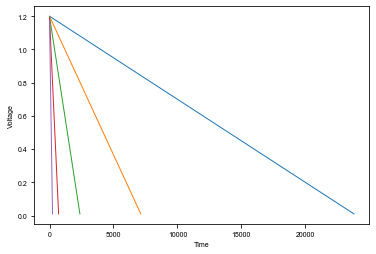

In [7]:
speeds = np.zeros((len(file_list), ))

for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    speeds[k] = speed
    
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    dVdt = np.gradient(data[:,2] * 1000) / np.gradient(data[:,1] / 60) # V/s -> mV/min
    
    mean = np.mean(dVdt)
    std = np.std(dVdt)
    print(speed , mean, std, std/mean)
    
    plt.plot(data[:,1] - data[0,1], data[:,2])
    
plt.xlabel('Time')
plt.ylabel('Voltage')

Add speed units from `pint`:

In [8]:
speeds_units = np.asarray(speeds) * ureg.mV / ureg.min
speeds_units

array([  3.,  10.,  30., 100., 300.]) <Unit('millivolt / minute')>

Default speed units should be V/s:

In [9]:
speeds_units.ito('V/s')
speeds_units

array([5.00000000e-05, 1.66666667e-04, 5.00000000e-04, 1.66666667e-03,
       5.00000000e-03]) <Unit('volt / second')>

## Create $\Delta I$ to determine baseline currents

One of the challenges with this system is deconvoluting the EC reduction reaction from the carbon black intercalation reaction. We get around this by subtracting the first lithiation from the second lithiation to bypass this. Then, to get the actual peak current values, I manually define values for the baseline by voltage:

In [10]:
V_baselines = [0.98, 0.9, 0.8, 0.61, 0.46]
ylim_bottoms = [-0.225, -0.6, -1.7, -2.4, -6.4]

I_baseline = np.zeros((5,))
I_peak = np.zeros((5,))
V_peak = np.zeros((5,))

Define a standard voltage basis vector for interpolation:

In [11]:
Vlin = np.linspace(0, 1.2, 1000)

Create plot:

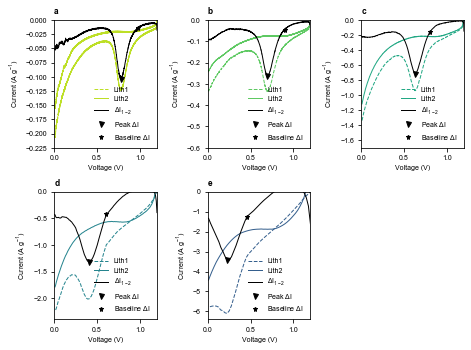

In [12]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=3)
ax = ax.ravel()

colors = cm.viridis(np.linspace(0.9, 0.3, 5))[:,0:3]

for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    
    # Find first and second lithiations.
    # data[:,0] indicates the redox mode
    idx = np.where(data[:,0] == 0)[0]
    
    # transition_point = index splitting first and second lithiations
    transition_point = idx[:-1][np.diff(idx) != 1][0]
    idx1 = idx[idx < transition_point]
    idx2 = idx[idx > transition_point]
    data1 = np.flip(data[idx1], axis=0)
    data2 = np.flip(data[idx2], axis=0)

    # create linearly interpolated current vectors to enable direct subtraction
    mass_in_mg = electrode_mass.to('mg').magnitude
    Ilin1 = np.interp(Vlin, data1[:,2], data1[:,3] / mass_in_mg)
    Ilin2 = np.interp(Vlin, data2[:,2], data2[:,3] / mass_in_mg)
    
    # Create DeltaI
    DeltaI = Ilin1 - Ilin2
    
    # Find peak current and voltage
    peak_idx = np.argmin(DeltaI)
    I_peak[k] = DeltaI[peak_idx]
    V_peak[k] = Vlin[peak_idx]
    
    # Identify baseline current from manually selected baseline voltage
    idx_baseline = np.where(Vlin > V_baselines[k])[0][0]
    I_baseline[k] = DeltaI[idx_baseline]
    
    # Plot
    ax[k].plot(data1[:,2], data1[:,3] / mass_in_mg, '--', color=colors[k], label='Lith1')
    ax[k].plot(data2[:,2], data2[:,3] / mass_in_mg, color=colors[k], label='Lith2')
    ax[k].plot(Vlin, DeltaI, color='k', label=r'$\Delta$I$_{1-2}$')
    ax[k].plot(V_peak[k], I_peak[k], 'vk', label=r'Peak $\Delta$I')
    ax[k].plot(V_baselines[k], I_baseline[k], '*k', label=r'Baseline $\Delta$I')
    
    # Plot settings
    ax[k].set_xlim([0, 1.2])
    ax[k].set_ylim(top=0, bottom=ylim_bottoms[k])
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_ylabel('Current (A g$^{-1}$)')
    ax[k].set_title(chr(97+k), loc='left', weight='bold')
    ax[k].legend()
    
ax[5].axis('off')
plt.tight_layout()
plt.savefig(figpath / 'LSV_baselines.eps', bbox_inches='tight', format='eps')

Define `I_peak_minus_I_baseline` (take negative to make positive):

In [13]:
I_peak_minus_I_baseline = -(I_peak - I_baseline)

## Compare to galvanostatic experiments

Code adapted from C rate notebook

### Load metadata

In [14]:
metadata = pd.read_csv(Path.cwd().parent / 'c rate' / 'masses.csv')
metadata

,File name,Mass (mg),C rate
0,cellA_Cover100_split_CA1,0.977,0.010000
1,cellA_Cover100_CC4,0.548,0.010000
2,cellC_Cover30_split_CC5,0.914,0.033333
3,cellD_Cover30_CC6,0.845,0.033333
4,cellA_Cover10_CC7,0.776,0.100000
5,cellE_Cover3_split_CC8,0.809,0.333333
6,cellC_Cover3_CF6,0.583,0.333333
7,cellG_1C_split_CD3,0.468,1.000000
8,cellM_1C_CD5,0.743,1.000000
9,cellF_3C_split_CF6,1.011,3.000000


### Load constant current data
Get data:

In [15]:
files_constcurr = list((Path.cwd().parent / 'c rate' / 'constant current data').glob('*.txt'))
files_constcurr

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover100_CC4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellJ_3C_CD8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellM_1C_CD5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_Cover3_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellD_Cover30_CC6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_10C_CF3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover10_CC7.txt')]

Parse and process:

In [16]:
all_data_constcurr = {}

for file in files_constcurr:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/')
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    try:
        third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
    except IndexError: # 10C data has only 2 cycles
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:, 1] == np.max(data[second_cycle_idx:, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    
    # Create dictionary    
    sub_dict['First lith data'] = first_lith_data
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
        
    # Append to main dictionary. We only want the high-rate data in this case tho
    if C_rate > 0.9:
        all_data_constcurr[file.stem] = sub_dict

# Sort
all_data_constcurr = {k: v for k, v in sorted(all_data_constcurr.items(), key=lambda item: item[1]['C rate'])}

cellA_Cover100_CC4: 0.01, C/100
cellJ_3C_CD8: 3, 3C
cellM_1C_CD5: 1, 1C
cellC_Cover3_CF6: 0.3333333333333333, C/3
cellD_Cover30_CC6: 0.03333333333333333, C/30
cellC_10C_CF3: 10, 10C
cellA_Cover10_CC7: 0.1, C/10


## Create final plot

Starting cellE_CB_LSV_3mVpermin_CB1
3 0.7793227066666666 0.08909758142340239
Starting cellF_CB_LSV_10mVpermin_CB2
10 0.6993227066666665 0.21644145005892365
Starting cellG_CB_LSV_30mVpermin_CB3
30 0.630229116190476 0.5519180860311999
Starting cellH_CB_LSV_100mVpermin_CB4
100 0.39215571 0.892285313297938
Starting cellI_CB_LSV_300mVpermin_CB5
300 0.22620249 2.14896928123254


/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in t

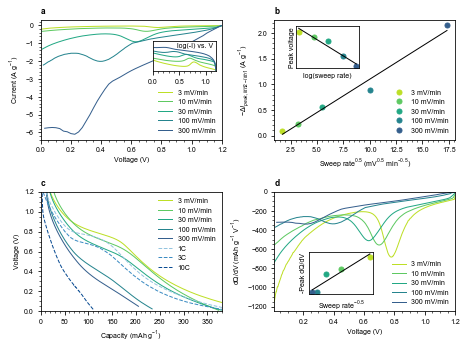

In [17]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=2)
ax = ax.ravel()

# Set main axes labels
for k in np.arange(len(ax)):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

# Plot settings
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Sweep rate$^{0.5}$ (mV$^{0.5}$ min$^{-0.5}$)')
ax[2].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[3].set_xlabel('Voltage (V)')

ax[0].set_ylabel('Current (A g$^{-1}$)')
ax[1].set_ylabel('$-\Delta I_{peak, lith2-lith1}$ (A g$^{-1}$)')
ax[2].set_ylabel('Voltage (V)')
ax[3].set_ylabel('dQ/dV (mAh g$^{-1}$ V$^{-1}$)')

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_xlim([0, 1.2])
ax[2].set_xlim([0, 380])
ax[2].set_ylim([0, 1.2])
ax[3].set_xlim([0.01, 1.2])
ax[3].set_ylim([-1250, 0])


ax_inset0 = inset_axes(ax[0], width='100%', height='100%',
                       bbox_to_anchor=(0.6, 0.6, 0.35, 0.25),
                       bbox_transform=ax[0].transAxes,
                       loc='upper left')
ax_inset1 = inset_axes(ax[1], width='100%', height='100%',
                       bbox_to_anchor=(0.1, 0.625, 0.35, 0.35),#(0.625, 0.15, 0.35, 0.35),
                       bbox_transform=ax[1].transAxes,
                       loc='upper left')
ax_inset3 = inset_axes(ax[3], width='100%', height='100%',
                       bbox_to_anchor=(0.175, 0.175, 0.35, 0.35),
                       bbox_transform=ax[3].transAxes,
                       loc='upper left')

ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset1.yaxis.set_minor_locator(AutoMinorLocator())
ax_inset3.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset3.yaxis.set_minor_locator(AutoMinorLocator())

ax_inset0.set_xlim([0, 1.2])
ax_inset0.set_ylim([1e-2, 30])

ax_inset1.set_xlabel('log(sweep rate)')
#ax_inset1.set_ylabel('$V_{peak}$ (V)', labelpad=0.8)
ax_inset1.set_ylabel('Peak voltage', labelpad=0.8)
ax_inset3.set_xlabel('Sweep rate$^{-0.5}$')
ax_inset3.set_ylabel('-Peak dQ/dV')


E_peaks = np.zeros((len(file_list), ))
I_peaks = np.zeros((len(file_list), ))
Delta_I_peaks = np.zeros((len(file_list), ))
dQdV_peaks = np.zeros((len(file_list), ))


colors_constcurr  = cm.Blues( np.linspace(0.4, 0.9, len(all_data_constcurr.items())))[:,0:3]


Vlin = np.linspace(0, 1.2, 1000)


for k, file in enumerate(file_list):
    
    print(f'Starting {file.stem}')
    
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    
    # Filter relevant data
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    
    # Get first and second lithiation sweeps
    idx_lith = np.where(data[:,0] == 0)[0] # first column = mode; mode = 0 or 1; 0 = lithiation
    
    transition_point = idx_lith[:-1][np.diff(idx_lith) != 1][0] # Get idx between 1st and 2nd lith sweep
    idx_lith1 = idx_lith[idx_lith < transition_point] # indices of first lith sweep
    idx_lith2 = idx_lith[idx_lith > transition_point] # indices of second lith sweep
    data_lith1 = data[idx_lith1] # data for first lith sweep
    data_lith2 = data[idx_lith2] # data for second lith sweep
    
    # Get columns
    time_lith1 = (data_lith1[:,1] - data_lith1[0,1]) / 3600
    time_lith2 = (data_lith2[:,1] - data_lith2[0,1]) / 3600
    voltage_lith1 = data_lith1[:,2]
    voltage_lith2 = data_lith2[:,2]
    current_lith1 = data_lith1[:,3] / mass_in_mg
    current_lith2 = data_lith2[:,3] / mass_in_mg
    I_lith1_lin = np.interp(Vlin, np.flip(voltage_lith1), np.flip(current_lith1))
    I_lith2_lin = np.interp(Vlin, np.flip(voltage_lith2), np.flip(current_lith2))
    I_diff = I_lith1_lin - I_lith2_lin
    
    # Numerically integrate
    Q_lith1 = 1000 * cumtrapz(y=-current_lith1, x=time_lith1) # mAh/mg -> mAh/g
    
    # Light smoothing
    if speed < 31:
        voltage_lith1 = savgol_filter(voltage_lith1, 21, 1)
        current_lith1 = savgol_filter(current_lith1, 21, 1)
        
    # Get dQ/dV
    dQdV_lith1 = current_lith1 / speed
    dQdV_lith1_derivative = np.gradient(Q_lith1, voltage_lith1[:-1])
    
    # Find index of peak current > 0.2 V
    idx_0pt2V = np.where(voltage_lith1 < 0.2)[0][0]
    max_idx = np.where(current_lith1[:idx_0pt2V] == np.min(current_lith1[:idx_0pt2V]))[0][0]
    E_peak_lith1 = voltage_lith1[max_idx]
    dQdV_peak_lith1 = dQdV_lith1[max_idx]
    print(speed, E_peak_lith1, I_peak_minus_I_baseline[k])
    
    # Set peaks
    E_peaks[k] = E_peak_lith1
    dQdV_peaks[k] = dQdV_peak_lith1
    
    # Plot
    ax[0].plot(voltage_lith1, current_lith1, color=colors[k],
            label=str(speed) + ' mV/min')
    ax[1].plot(speed**0.5, I_peak_minus_I_baseline[k], 'o', color=colors[k],
               label=str(speed) + ' mV/min')
    ax[2].plot(Q_lith1, voltage_lith1[:-1], color=colors[k],
            label=str(speed) + ' mV/min')
    ax[3].plot(voltage_lith1, 60 / 3.6 * 1000 * current_lith1 / speed, color=colors[k],
              label=str(speed) + ' mV/min')
    
    # dQ/dV is numerically equivalent to current / sweep rate.
    # You can confirm this with below lines
    #ax[3].plot(voltage[:-1], dQdV_derivative, ':', color=colors[k],
    #          label=str(speed) + ' mV/min')
    
    ax_inset0.semilogy(voltage_lith1, -current_lith1, color=colors[k])
    ax_inset1.semilogx(speed, E_peak_lith1, 'o', color=colors[k])
    ax_inset3.plot(speed**-0.5, -dQdV_peak_lith1, 'o', color=colors[k],
                   label=str(speed) + ' mV/min')
    

# Add constant current V vs Q
for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[2].plot(Q, V, '--', color=colors_constcurr[k], label=C_rate_string)
    

ax[0].legend(frameon=False)
ax[1].legend(frameon=False, loc='lower right')
ax[2].legend(frameon=False)
ax[3].legend(frameon=False)


ax_inset0.annotate('log(-I) vs. V', (0.95, 0.95), xycoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top')

# Fits
speeds_logspace = np.logspace(np.log10(speeds[0]), np.log10(speeds[-1]), 100)

p1 = np.polyfit(speeds**0.5, I_peak_minus_I_baseline, 1)
p2 = np.polyfit(np.log10(speeds), E_peaks, 1)
p3 = np.polyfit(speeds**(-0.5), -dQdV_peaks, 1)

ax[1].plot(speeds_logspace**0.5, p1[0]*speeds_logspace**0.5 + p1[1], 'k')
ax_inset1.semilogx(speeds_logspace, p2[0]*np.log10(speeds_logspace) + p2[1], 'k')
ax_inset3.plot(speeds_logspace**(-0.5), p3[0]*speeds_logspace**(-0.5) + p3[1], 'k')

ax_inset0.get_yaxis().set_ticks([])
ax_inset1.get_xaxis().set_ticks([])
ax_inset1.minorticks_off()
ax_inset1.get_yaxis().set_ticks([])
ax_inset3.get_xaxis().set_ticks([])
ax_inset3.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig(figpath / 'LSV.eps', bbox_inches='tight', format='eps')